# The Hadamard Test

In [5]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

## Hadamard Test

The simplest way to estimate $\varphi$ with a quantum computer is to use the Hadamard test. This test is a very useful tool for estimating the expectation value of a unitary operator with respect to some state, i.e., $\langle \psi|U|\psi\rangle$. Our unitary operator $U$ is not generally a Hermitian matrix meaning its eigenvalues can be complex. Therefore this does not correspond to the measurement of a physical observable, which means we need to encode it into something physical we can measure. For this method, we measure the real and imaginary part of the expectation value seperately.

Lets start by looking at the the real and imaginary Hadamard Test Circuits.

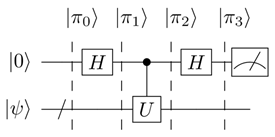

$$\text{Fig. }5:\text{ Hadamard test for Re}\langle\psi |U|\psi\rangle$$

The unitary operator $U$ will apply the phase of $|\psi\rangle$ onto $q_0$.

### Proof

Looking at the real Hadamard test in $\text{Fig. }3$, the intial state of our circuit can be represented as

$$|\pi_0\rangle = |0\rangle \otimes |\psi\rangle = |0\rangle|\psi\rangle = \begin{pmatrix}1 \\ 0\end{pmatrix}|\psi\rangle$$

We then apply the Hadamard gate to the control qubit transforming it to the $|+\rangle$ state

$$|\pi_1\rangle 
= (H \otimes I) \cdot (|0\rangle|\psi\rangle)
= H|0\rangle I|\psi\rangle
= \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}\begin{pmatrix}1\\0\end{pmatrix}|\psi\rangle
= \frac{1}{\sqrt{2}}\begin{pmatrix} (1\cdot 1) + (1\cdot 0) \\(1\cdot 1) + (-1\cdot 0) \end{pmatrix}|\psi\rangle 
= \frac{1}{\sqrt{2}}\begin{pmatrix} 1\\1 \end{pmatrix}|\psi\rangle
= \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle \right)|\psi\rangle 
= |+\rangle|\psi\rangle$$

Next the controlled-unitary operator is performed resulting in the following state rotating $q_0$ equivent to the eigenvalue of $|\psi\rangle$

$$|\pi_2\rangle 
= CU|+\rangle|\psi\rangle
= \frac{1}{\sqrt{2}}|0\rangle|\psi\rangle + \frac{1}{\sqrt{2}} |1\rangle U|\psi\rangle 
= \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 0\\0 & e^{i\theta}\end{pmatrix}\begin{pmatrix} 1\\1 \end{pmatrix}|\psi\rangle 
= \frac{1}{\sqrt{2}} \begin{pmatrix} (1\cdot 1) + (0\cdot 1) \\ (0\cdot 1) + (1\cdot e^{i\theta})\end{pmatrix}|\psi\rangle 
= \frac{1}{\sqrt{2}} \begin{pmatrix} 1\\ e^{i\theta}\end{pmatrix}|\psi\rangle 
= \frac{1}{\sqrt{2}}\left(|0\rangle + e^{i\theta}|1\rangle \right)|\psi\rangle$$

Finally, we apply the second Hadamard gate to the circuit leaving us with the state

$$|\pi_3\rangle = H\frac{1}{\sqrt{2}}\left(|0\rangle + e^{i\theta}|1\rangle \right)|\psi\rangle = \frac{1}{2}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}\begin{pmatrix} 1\\ e^{i\theta}\end{pmatrix}|\psi\rangle = \frac{1}{2}\begin{pmatrix} (1\cdot 1) + (1\cdot e^{i\theta}) \\(1\cdot 1) + (-1\cdot e^{i\theta})\end{pmatrix}|\psi\rangle = \frac{1}{2}\begin{pmatrix} 1 + e^{i\theta} \\1 - e^{i\theta}\end{pmatrix}|\psi\rangle = \left(\frac{1+e^{i\theta}}{2}|0\rangle + \frac{1-e^{i\theta}}{2}|1\rangle\right)|\psi\rangle$$

For simplicity in calculating the probabilities, this can also be represented as matrix operations on $|\psi\rangle$
$$|0\rangle\frac{I+U}{2}|\psi\rangle + |1\rangle\frac{I-U}{2}|\psi\rangle$$

Since we know the probability of a quantum state comes from the probability amplitude times its complex conjugate, we can calculate the final probablities. We will first look at the probability of measuring the qubit $0$ to be in the $|0\rangle$ state.

$$\mathbb{P}_{\text{Re}}(|0\rangle) 
= |\langle 0|\pi_3\rangle|^2 
=\left| \langle 0|0\rangle\frac{I+U}{2}|\psi\rangle + \langle0|1\rangle\frac{I-U}{2}|\psi\rangle\right|^2 
= \left|\frac{I+U}{2}|\psi\rangle\right|^2 
= \frac{\langle \psi|(I+U^{\dagger})(I+U)|\psi\rangle}{4} 
= \frac{\langle \psi|(I+U+U^{\dagger}+U^{\dagger}U)|\psi\rangle}{4}$$

If we now take a similar process for the probability of measuring qubit $0$ to be in the $|1\rangle$ state, we get the following

$$\mathbb{P}_{\text{Re}}(|1\rangle) 
= |\langle 1|\pi_3\rangle|^2 
= \left| \langle 1|0\rangle\frac{I+U}{2}|\psi\rangle + \langle 1|1\rangle\frac{I-U}{2}|\psi\rangle\right|^2 
= \left|\frac{I-U}{2}|\psi\rangle\right|^2 
= \frac{\langle \psi|(I-U^{\dagger})(I-U)|\psi\rangle}{4} 
= \frac{\langle \psi|(I-U-U^{\dagger}+U^{\dagger}U)|\psi\rangle}{4}$$

Using the fact that $U^\dagger U = I$, these probabilites can be simplified further

$$\mathbb{P}_{\text{Re}}(|0\rangle) =  \frac{\langle \psi|(I+U+U^{\dagger}+U^{\dagger}U)|\psi\rangle}{4} = \frac{\langle \psi|(2I+U+U^{\dagger})|\psi\rangle}{4} = \frac{2 + \langle \psi|(U+U^{\dagger})|\psi\rangle}{4}$$

$$\mathbb{P}_{\text{Re}}(|1\rangle) =  \frac{\langle \psi|(I-U-U^{\dagger}+U^{\dagger}U)|\psi\rangle}{4} = \frac{\langle \psi|(2I-U-U^{\dagger})|\psi\rangle}{4} = \frac{2 - \langle \psi|(U+U^{\dagger})|\psi\rangle}{4}$$

For a unitary operator $U$, $\langle\alpha|U|\beta\rangle = (\langle\alpha|U|\beta\rangle)^\dagger = \langle\beta|U^{\dagger}|\alpha\rangle$, therefore if $\alpha = \beta$ such as in our case, $\langle\psi|U|\psi\rangle = \langle\psi|U^{\dagger}|\psi\rangle$. Applying this to our probablity equations, we get the following:

$$\mathbb{P}_{\text{Re}}(|0\rangle) = \frac{2 + \langle \psi|(U+U^{\dagger})|\psi\rangle}{4} = \frac{2 + 2\text{Re}\langle\psi|U|\psi\rangle}{4} = \frac{1}{2}(1+\text{Re}\langle\psi|U|\psi\rangle)$$

$$\mathbb{P}_{\text{Re}}(|1\rangle) = \frac{2 - \langle \psi|(U+U^{\dagger})|\psi\rangle}{4} = \frac{2 - 2\text{Re}\langle\psi|U|\psi\rangle}{4} = \frac{1}{2}(1-\text{Re}\langle\psi|U|\psi\rangle)$$

Now that we have the probability of measuring $|0\rangle$ on $q_0$ and the probability of measuring $|1\rangle$ on $q_0$, we can now calculate the real component of the phase.

$$\mathbb{P}_{\text{Re}}(|0\rangle) - \mathbb{P}_{\text{Re}}(|1\rangle) 
= \frac{1}{2}(1+\text{Re}\langle\psi|U|\psi\rangle) - \frac{1}{2}(1-\text{Re}\langle\psi|U|\psi\rangle)
= \frac{1}{2}\text{Re}\langle\psi|U|\psi\rangle + \frac{1}{2}\text{Re}\langle\psi|U|\psi\rangle
=  \text{Re}\langle\psi|U|\psi\rangle$$

$$2\mathbb{P}_{\text{Re}}(|0\rangle) - 1
= 2 \left(\frac{1}{2}(1+\text{Re}\langle\psi|U|\psi\rangle)\right) - 1
=  (1+\text{Re}\langle\psi|U|\psi\rangle)  - 1
=  \text{Re}\langle\psi|U|\psi\rangle$$

$$1 - 2\mathbb{P}_{\text{Re}}(|1\rangle)
=  1  2 \left(\frac{1}{2}(1-\text{Re}\langle\psi|U|\psi\rangle)\right)
=  1-(\text{Re}\langle\psi|U|\psi\rangle - 1)
=  \text{Re}\langle\psi|U|\psi\rangle$$

Therefore, the real expectation value can be found from these probabilities in the following three different ways:

\begin{equation}
\begin{aligned}
\mathbb{P}_{\text{Re}}(|0\rangle) - \mathbb{P}_{\text{Re}}(|1\rangle) = 2\mathbb{P}_{\text{Re}}(|0\rangle) - 1 = 1 - 2\mathbb{P}_{\text{Re}}(|1\rangle) =\text{Re}\langle\psi|U|\psi\rangle 
\end{aligned}
\tag{1}
\end{equation}

The approach to obtain the imaginary part of the expectation value is almost exactly the same as the real part. This time, though, we will use the imaginary Hadamard test circuit which contains the addition of a phase gate $S = \begin{pmatrix} 1 & 0\\0 & i\end{pmatrix}$ on the control qubit as shown in $\text{Fig. }6$. 

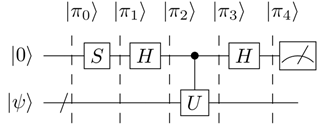

$$\text{Fig. }6:\text{ Hadamard test for Im}\langle\psi |U|\psi\rangle$$

The first two states $|\pi_0\rangle$ and $|\pi_1\rangle$ are the same as for the real test.

$$|\pi_0\rangle = |0\rangle|\psi\rangle = \begin{pmatrix}1\\0\end{pmatrix}|\psi\rangle$$

$$|\pi_1\rangle = H|0\rangle|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}\begin{pmatrix}1\\0\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1\\1 \end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle \right)|\psi\rangle = |+\rangle|\psi\rangle$$

Now the phase gate $S$ is applied to this state giving us the following

$$|\pi_2\rangle = S|+\rangle|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 0\\0 & i\end{pmatrix}\begin{pmatrix} 1\\1\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} (1\cdot 1) +  (0\cdot 1)\\(0\cdot 1) + (i\cdot 1)\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1\\i\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + i|1\rangle \right)|\psi\rangle$$

Performing the controlled-$U$ we get

$$|\pi_3\rangle = \frac{1}{\sqrt{2}}|0\rangle|\psi\rangle + \frac{1}{\sqrt{2}}i|1\rangle U|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 0\\0 & e^{i\theta}\end{pmatrix}\begin{pmatrix} 1\\i\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} (1\cdot 1) + (0\cdot i) \\(0\cdot 1) + (e^{i\theta}\cdot i)\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1\\ie^{i\theta}\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}(|0\rangle + ie^{i\theta}|1\rangle)|\psi\rangle$$

Lastly, we apply the second Hadamard gate to the state which gives

$$|\pi_4\rangle = H\frac{1}{\sqrt{2}}(|0\rangle + ie^{i\theta}|1\rangle)|\psi\rangle = \frac{1}{2}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}\begin{pmatrix} 1\\ie^{i\theta}\end{pmatrix}|\psi\rangle = \frac{1}{2}\begin{pmatrix} (1\cdot 1) + (1\cdot ie^{i\theta}) \\(1\cdot 1) + (-1\cdot ie^{i\theta})\end{pmatrix}|\psi\rangle = \frac{1}{2}\begin{pmatrix} 1 + ie^{i\theta} \\1 - ie^{i\theta}\end{pmatrix}|\psi\rangle = \left(\frac{1+ie^{i\theta}}{2}|0\rangle + \frac{1-ie^{i\theta}}{2}|1\rangle\right)|\psi\rangle$$

Similar to our analysis of the real test, this can also be written as the following

$$|0\rangle\frac{I+iU}{2}|\psi\rangle + |1\rangle\frac{I-iU}{2}|\psi\rangle$$

Using the same approach as before for calculating the probabilities, measuring qubit $0$ to be in the $|0\rangle$ state for the imaginary test we have

$$\mathbb{P}_{\text{Im}}(|0\rangle) = |\langle 0|\pi_3\rangle |^2 = \left|\langle 0|0\rangle\frac{I+iU}{2}|\psi\rangle\right|^2 = \left|\frac{I+iU}{2}|\psi\rangle\right|^2 = \frac{\langle \psi|(I-iU^{\dagger})(I+iU)|\psi\rangle}{4} = \frac{\langle \psi|(I+iU-iU^{\dagger}+U^{\dagger}U)|\psi\rangle}{4}$$

And again for measuring qubit $0$ to be in the $|1\rangle$ state

$$\mathbb{P}_{\text{Im}}(|1\rangle) = |\langle 0 | \pi_3 \rangle|^2 = \left|\langle 0|0\rangle\frac{I-iU}{2}|\psi\rangle\right|^2 = \left|\frac{I-iU}{2}|\psi\rangle\right|^2 = \frac{\langle \psi|(I+iU^{\dagger})(I-iU)|\psi\rangle}{4} = \frac{\langle \psi|(I-iU+iU^{\dagger}+U^{\dagger}U)|\psi\rangle}{4}$$

We can simplify probabilities further using similar step to the real circuit

$$\mathbb{P}_{\text{Im}}(|0\rangle) =  \frac{\langle \psi|(I+iU-iU^{\dagger}+U^{\dagger}U)|\psi\rangle}{4} = \frac{2+\langle \psi|iU|\psi\rangle-\langle \psi|iU^{\dagger}|\psi\rangle}{4} = \frac{1}{2}+i\frac{\langle \psi|U|\psi\rangle-\langle \psi|U^{\dagger}|\psi\rangle}{4} = \frac{1}{2}-
\frac{2\text{Im}\langle\psi|U|\psi\rangle}{4} = \frac{1}{2}(1 - \text{Im}\langle\psi|U|\psi\rangle)$$

$$\mathbb{P}_{\text{Im}}(|1\rangle) =  \frac{\langle \psi|(I-iU+iU^{\dagger}+U^{\dagger}U)|\psi\rangle}{4} = \frac{2-\langle \psi|iU|\psi\rangle+\langle \psi|iU^{\dagger}|\psi\rangle}{4} = \frac{1}{2}-i\frac{\langle \psi|U|\psi\rangle-\langle \psi|U^{\dagger}|\psi\rangle}{4} = \frac{1}{2} + \frac{2\text{Im}\langle\psi|U|\psi\rangle}{4} = \frac{1}{2}(1 - \text{Im}\langle\psi|U|\psi\rangle)$$

Following the same rules mentioned for the real test, if we subtract $\mathbb{P}_0(|0\rangle)$ from $\mathbb{P}_0(|1\rangle)$ we should be left with the imaginary part of the expectation value $\text{Im}\langle\psi|U|\psi\rangle$.

$$\mathbb{P}_{\text{Im}}(|1\rangle) - \mathbb{P}_{\text{Im}}(|0\rangle) = \frac{1}{2}(1 - \text{Im}\langle\psi|U|\psi\rangle) - \frac{1}{2}(1 - \text{Im}\langle\psi|U|\psi\rangle) = \text{Im}\langle\psi|U|\psi\rangle$$

Therefore, we can find the imaginary expectation value in the following three ways:

\begin{equation}
\begin{aligned}
\mathbb{P}_{\text{Im}}(|1\rangle) - \mathbb{P}_{\text{Im}}(|0\rangle) = 1 - 2\mathbb{P}_{\text{Im}}(|0\rangle) = 2\mathbb{P}_{\text{Im}}(|1\rangle) - 1 =\text{Im}\langle\psi|U|\psi\rangle
\end{aligned}
\tag{2}
\end{equation}

By combining these real and imaginary results, we can estimate the expectation value $\langle\psi|U|\psi\rangle$.

Since we know our eigenvalue is $e^{i\theta}$, we can use Euler's formula to convert this to $\cos\theta + i\sin\theta$ where $\cos\theta$ is the real part and $\sin\theta$ is the imaginary part. Thus $\text{Re}\langle\psi|U|\psi\rangle = \cos\theta$ and $\text{Im}\langle\psi|U|\psi\rangle = \sin\theta$. So our real probabilities can be written as

$$\mathbb{P}_{\text{Re}}(|0\rangle) = \frac{1}{2}(1+\text{Re}\langle\psi|U|\psi\rangle) = \frac{1}{2}(1+\cos\theta)$$

$$\mathbb{P}_{\text{Re}}(|1\rangle) = \frac{1}{2}(1-\text{Re}\langle\psi|U|\psi\rangle) = \frac{1}{2}(1-\cos\theta)$$

Therefore $\theta$ can be estimated with the following

$$\theta \approx \arccos(2\mathbb{P}_{\text{Re}}(|0\rangle) - 1) = \arccos(1 - 2\mathbb{P}_{\text{Re}}(|1\rangle))$$

We can do the same with the imaginary part of Euler's formula and our expectation value:

$$\mathbb{P}_{\text{Im}}(|0\rangle) = \frac{1}{2}(1-\text{Im}\langle\psi|U|\psi\rangle) = \frac{1}{2}(1-\sin\theta)$$

$$\mathbb{P}_{\text{Im}}(|1\rangle) = \frac{1}{2}(1+\text{Im}\langle\psi|U|\psi\rangle) = \frac{1}{2}(1+\sin\theta)$$

Thus $\theta$ can also be estimated with the following

$$\theta \approx \arcsin(1 - 2\mathbb{P}_{\text{Im}}(|0\rangle)) = \arcsin(2\mathbb{P}_{\text{Im}}(|1\rangle) - 1)$$

Finally, $\theta$ can also be estimated using both the imaginary and real expectation values. Let's think about the real and imaginary expectation values as vectors on the complex unit circle shown in $\text{Fig. }5$ where the real part is on the $x$-axis and the imaginary is on the $y$-axis. By taking the $\arcsin$ of the imaginary part or the $\arccos$ of the real part we are effectively finding the vector of the whole complex expectation value. This means that we can also take the $\arctan$ of the imaginary part over the real part to find $\theta$ as well. Though using both parts does increase the error of the estimation as it is using data from two different circuits rather than just one.

Therefore, we can estimate the angle $\theta$ with the following three methods:

\begin{equation}
\begin{aligned}
\theta = \arccos(\text{Re}\langle\psi|U|\psi\rangle) = \arcsin(\text{Im}\langle\psi|U|\psi\rangle) = \arctan\left(\frac{\text{Im}\langle\psi|U|\psi\rangle}{\text{Re}\langle\psi|U|\psi\rangle}\right)
\end{aligned}
\tag{3}
\end{equation}

Let's run the circuits in Qiskit to estimate the phase using a value of $\theta$ = 0.5625:

### Verification

In [4]:
angle = 0.5625 #Exact value of phi to estimate

In [5]:
def re_circuit(theta):
    circuit = QuantumCircuit(2,1) #Create circuit with 2 qubits and 1 classical bit
    circuit.x(1) #Apply pauli-x gate to q1 to put it to 1 state
    circuit.barrier(label='$|π_0$\u27e9')    
    circuit.h(0) #Apply hadamard gate to q0 to put it into + state
    circuit.barrier(label='$|π_1$\u27e9') 
    circuit.cp(theta,0,1) # rotates q0 2*pi*theta radians if q1 is 1
    circuit.barrier(label='$|π_2$\u27e9') 
    circuit.h(0) #Apply second hadamard gate to q0 to ensure the value phi affects our output
    circuit.barrier(label='$|π_3$\u27e9')
    circuit.measure(0,0) #Measure q0
    return circuit

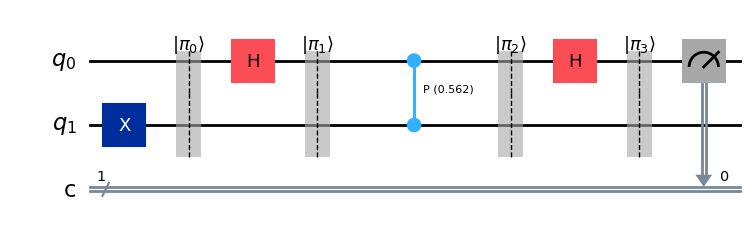

In [6]:
qc = re_circuit(angle)
qc.draw('mpl')

$$\text{Fig. }8:\text{ Hadamard test for Re}\langle\psi |U|\psi\rangle$$

In [7]:
def im_circuit(theta):
    circuit = QuantumCircuit(2,1) #Create circuit with 2 qubits and 1 classical bit
    circuit.x(1) #Apply pauli-x gate to q1 to put it to 1 state
    circuit.barrier(label='$|π_0\u27e9$')
    circuit.h(0) #Apply hadamard gate to q0 to put it into + state
    circuit.barrier(label='$|π_1$\u27e9')
    circuit.s(0) #Apply phase gate to make imaginary
    circuit.barrier(label='$|π_2$\u27e9')
    circuit.cp(theta,0,1) #Rotates q0 2*pi*theta radians if q1 is 1
    circuit.barrier(label='$|π_3$\u27e9')
    circuit.h(0) #Apply second hadamard gate to q0 to ensure the value phi affects our output
    circuit.barrier(label='$|π_4$\u27e9')
    circuit.measure(0,0) #Measure q0
    return circuit

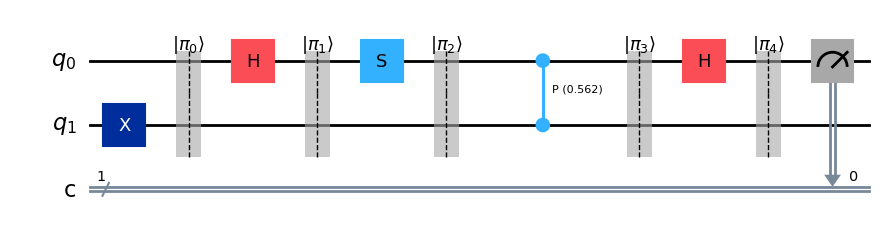

In [8]:
qc2 = im_circuit(angle)
qc2.draw('mpl')

$$\text{Fig. }9:\text{ Hadamard test for Re}\langle\psi |U|\psi\rangle$$

In [47]:
backend = BasicSimulator()

num_of_shots = 10000

re_result = backend.run(qc, shots=num_of_shots).result()   
re_counts = re_result.get_counts()                    

im_result = backend.run(qc2, shots=num_of_shots).result()   
im_counts = im_result.get_counts()                

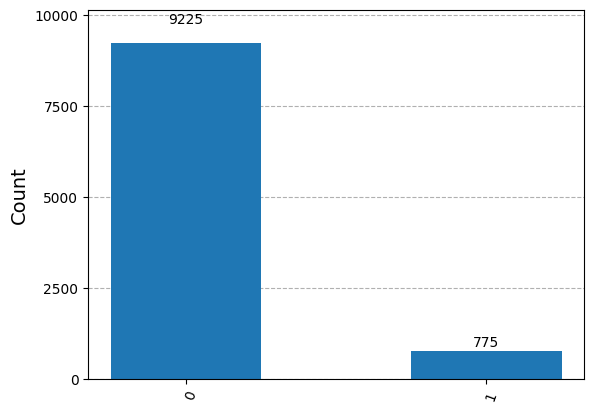

In [48]:
plot_histogram(re_counts)

$$\text{Fig. }10:\text{ Real Hadamard test counts}$$

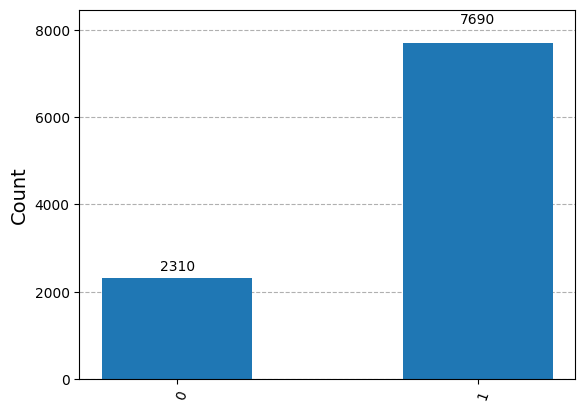

In [11]:
plot_histogram(im_counts)

$$\text{Fig. }11:\text{ Imaginary Hadamard test counts}$$

Using our computed equations for the measured probabilities $\mathbb{P}_{\text{Re}}(|0\rangle)$ and $\mathbb{P}_{\text{Re}}(|1\rangle)$, we can check that they match what we get from running the circuit.

$$\mathbb{P}_{\text{Re}}(|0\rangle) = \frac{1}{2}(1+\cos\theta) = \frac{1}{2}(1+\cos(0.5625)) \approx 0.9230$$

$$\mathbb{P}_{\text{Re}}(|1\rangle) = \frac{1}{2}(1-\cos\theta) = \frac{1}{2}(1-\cos(0.5625)) \approx 0.0770$$

Comparing this to the probabilites from the circuit, we can see they are very close to what we expect so we can say they do indeed match.

$$\mathbb{P}_{\text{Re}}(|0\rangle) = 0.9212$$

$$\mathbb{P}_{\text{Re}}(|1\rangle) = 0.0788$$

We can again do the same for the imaginary circuit where our computed probabilites are as follows

$$\mathbb{P}_{\text{Im}}(|0\rangle) = \frac{1}{2}(1-\sin\theta) = \frac{1}{2}(1-\sin(0.5625)) \approx 0.2333$$

$$\mathbb{P}_{\text{Im}}(|1\rangle) = \frac{1}{2}(1+\sin\theta) = \frac{1}{2}(1+\sin(0.5625)) \approx 0.7667$$

And comparing these to the probabilities from the circuit we again see that they are very close and matchup.

$$\mathbb{P}_{\text{Im}}(|0\rangle) = 0.23411$$

$$\mathbb{P}_{\text{Im}}(|1\rangle) = 0.76589$$


In [12]:
print('For Real Part:\nCalculated probability of measuring 0:\t',0.5*(1 + np.cos(angle)))
print('Calculated probability of measuring 1:\t', 0.5*(1 - np.cos(angle)))

print('Probability of measuring 0:\t\t', re_counts['0']/num_of_shots)
print('Probability of measuring 1:\t\t', re_counts['1']/num_of_shots)

print('\nFor Imaginary Part:\nCalculated probability of measuring 0:\t',0.5*(1 - np.sin(angle)))
print('Calculated probability of measuring 1:\t', 0.5*(1 + np.sin(angle)))

print('Probability of measuring 0:\t\t', im_counts['0']/num_of_shots)
print('Probability of measuring 1:\t\t', im_counts['1']/num_of_shots)

For Real Part:
Calculated probability of measuring 0:	 0.922962249615534
Calculated probability of measuring 1:	 0.07703775038446603
Probability of measuring 0:		 0.9229
Probability of measuring 1:		 0.0771

For Imaginary Part:
Calculated probability of measuring 0:	 0.23334866323198994
Calculated probability of measuring 1:	 0.7666513367680101
Probability of measuring 0:		 0.231
Probability of measuring 1:		 0.769


We can also clearly see that these probabilities both sum to $1$ which is what we expect. If we cycle through values of $\theta$ from $0\text{ rad}$ to $2\pi\text{ rad}$ and plot the probabilities of measuring $|1\rangle$ or $|0\rangle$, we can see that they always sum to 1.

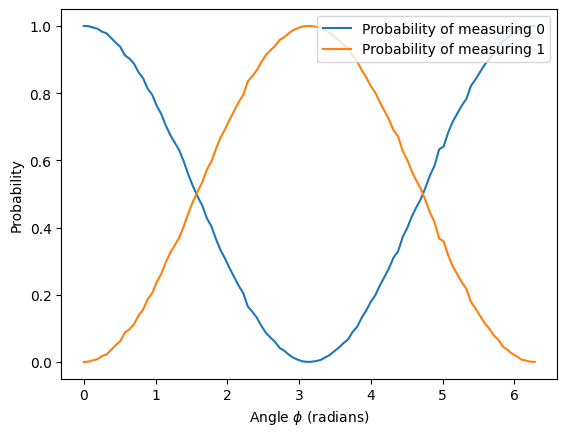

In [33]:
backend = BasicSimulator()

angles = np.linspace(0, 2*pi, 100)
prob0 = []
prob1 = []
expected_phi = angles
for ang in angles:
    circ = re_circuit(ang)
    num_of_shots = int(num_of_shots)
    counts = backend.run(circ, shots=num_of_shots).result().get_counts()
    prob0val = counts.get('0')
    prob1val = counts.get('1')
    if prob0val is not None and prob1val is not None:        
        prob0.append(counts['0']/num_of_shots)
        prob1.append(counts['1']/num_of_shots)
    elif prob0val is None:
        prob0.append(0)
        prob1.append(counts['1']/num_of_shots)
    elif prob1val is None:
        prob1.append(0)
        prob0.append(counts['0']/num_of_shots)
plt.plot(angles, prob0, label = 'Probability of measuring 0')
plt.plot(angles, prob1, label = 'Probability of measuring 1')
plt.xlabel('Angle $\phi$ (radians)')
plt.ylabel('Probability')
plt.legend(loc = 'upper right')
plt.show()

$$\text{Fig. }12:\text{ Probabilities of measuring }0\text{ and }1\text{ for the Hadamard test}$$

Now that we have obtained the probabilities for each circuit, we can compute $\text{Re}\langle\psi|U|\psi\rangle$ using any equation in $(1)$ and $\text{Im}\langle\psi|U|\psi\rangle$ using any equation in $(2)$. 

In [13]:
print("Results of the Trial: ")
print("  Real Circuit:  \t",re_counts)
print("  Imginary Circuit:\t",im_counts)

re_p0 = re_counts['0']/num_of_shots
re_p1 = re_counts['1']/num_of_shots
im_p0 = im_counts['0']/num_of_shots
im_p1 = im_counts['1']/num_of_shots

re = re_p0 - re_p1
#re = 2*(re_p0) - 1
#re = 1 - 2*(re_p1)

im = im_p1 - im_p0
#im = 1 - 2*(im_p0)
#im = 2*(im_p1) - 1

print('\nRe\u27e8\u03c8|U|\u03c8\u27e9 = ',re)
print('Im\u27e8\u03c8|U|\u03c8\u27e9 = ',im)

Results of the Trial: 
  Real Circuit:  	 {'0': 9229, '1': 771}
  Imginary Circuit:	 {'1': 7690, '0': 2310}

Re⟨ψ|U|ψ⟩ =  0.8458000000000001
Im⟨ψ|U|ψ⟩ =  0.538


Finally, we can use either or both of these values to estimate the phase angle $\theta$ using any equation in $(3)$.

In [14]:
ans = np.arcsin(im)
#ans = np.arccos(re)
#ans = np.arctan(im/re)

print("\nEstimated phase angle:\t", ans)
print("Exact phase angle:\t", angle)


Estimated phase angle:	 0.5680626734972267
Exact phase angle:	 0.5625


We have now successfuly estimated the angle $\theta = 0.5625$ to be $\theta \approx 0.5595$. The accuracy of this estimation is directly dependent on the number of shots or how many times the circuit is run. The more shots we use, the more accurate our probabilites will be and thus our expectaions values and phase angle will be estimated to higher precision. By running this circuit for an increasing number of shots, we can see the convergence of the error with respect to the number of shots.

In [72]:
# Construct a graph of error verses number of shots
backend = BasicSimulator()

trials = np.logspace(2, 5, 20)
Ns = []
error_diff = []
for num_of_shots in trials:
    # for some reason python doesn't believe this number is an integer
    num_of_shots = int(num_of_shots)
    re_counts = backend.run(qc, shots=num_of_shots).result().get_counts() 
    im_counts = backend.run(qc2, shots=num_of_shots).result().get_counts() 

    re_p0 = re_p1 = im_p0 = im_p1 = 0
    
    if re_counts.get('0') is not None:
        re_p0 = re_counts['0']/num_of_shots
        
    if re_counts.get('1') is not None:
        re_p1 = re_counts['1']/num_of_shots
        
    if im_counts.get('0') is not None:
        im_p0 = im_counts['0']/num_of_shots
        
    if im_counts.get('1') is not None:
        im_p1 = im_counts['1']/num_of_shots

    re = re_p0 - re_p1
    im = im_p1 - im_p0
    ans = np.arctan(im/re)
    
    error_diff.append((4*ans*(1 - ans)/num_of_shots)**(0.5))
    Ns.append( num_of_shots**(-0.5) )

error_diff=np.array(error_diff)

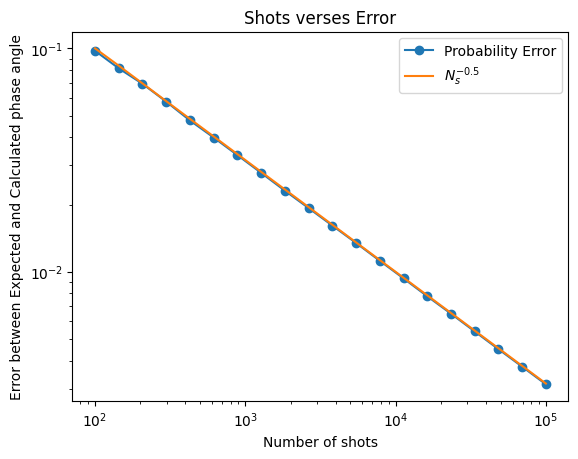

In [73]:
plt.loglog(trials, error_diff, label = 'Probability Error',marker='o')
plt.loglog(trials, Ns, label = '$N_s^{-0.5}$')
plt.title("Shots verses Error")
plt.xlabel("Number of shots")
plt.ylabel("Error between Expected and Calculated phase angle")
plt.legend(loc='upper right')
plt.show()

$$\text{Fig. }13:\text{ Error convergence with respect to number of shots}$$